<a href="https://colab.research.google.com/github/morenourey/CHAT/blob/main/clasificacion_pedidos_a_domicilio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import libraries

In [1]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.9 MB/s eta 0:00:00


In [2]:
# cálculos
import numpy as np
import pandas as pd
import math

# fechas
from datetime import datetime

# gráficos
import seaborn as sns
import matplotlib.pyplot as plt

# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# modelos
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# metricas
import sklearn.metrics as metrics

# hiperparametrizado
from sklearn.model_selection import GridSearchCV

# quitar alertas
import warnings
warnings.filterwarnings("ignore")

# Import data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv("/content/drive/MyDrive/NUCLIO/pedidos_entrenar.csv")
df_pred = pd.read_csv("/content/drive/MyDrive/NUCLIO/pedidos_predecir.csv")

In [5]:
df

,order_id,local_time,country_code,store_address,payment_status,n_of_products,products_total,final_status
0,33446280,14:11:09,AR,55379,PAID,2,11.88,DeliveredStatus
1,33107339,11:47:41,GT,23487,PAID,2,5.20,DeliveredStatus
2,32960645,11:53:53,CR,62229,PAID,1,6.03,DeliveredStatus
3,32089564,20:15:21,ES,29446,PAID,6,6.37,DeliveredStatus
4,32157739,21:32:16,AR,13917,PAID,1,5.36,CanceledStatus
...,...,...,...,...,...,...,...,...
54325,33443728,13:54:33,AR,63825,PAID,2,10.39,DeliveredStatus
54326,33499561,17:16:09,AR,27741,PAID,1,9.07,DeliveredStatus
54327,32895248,20:14:59,PA,65895,PAID,2,1.65,DeliveredStatus
54328,32792276,13:24:05,ES,20134,PAID,6,8.04,DeliveredStatus


In [6]:
df_pred

,order_id,local_time,country_code,store_address,payment_status,n_of_products,products_total
0,32240990,18:38:08,ES,8220,REFOUND,11,15.99
1,32960491,18:56:17,MA,32273,NOT_PAID,2,1.79
2,32430153,13:43:26,PA,17782,PAID,5,29.89
3,32777553,09:03:00,TR,28205,PAID,1,1.47
4,32324328,21:15:20,AR,64309,PAID,1,4.20
5,33047576,11:42:08,UA,61562,PAID,6,18.73
6,33293677,20:03:33,ES,22022,PAID,1,3.80
7,32073867,14:12:57,DO,48440,PAID,1,6.25
8,32732256,21:31:36,ES,18667,PAID,2,14.50
9,32152540,18:58:35,EC,41406,PAID,1,21.10


# data cleaning

In [7]:
# info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54330 entries, 0 to 54329
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   order_id        54330 non-null  int64  
 1   local_time      54330 non-null  object 
 2   country_code    54330 non-null  object 
 3   store_address   54330 non-null  int64  
 4   payment_status  54330 non-null  object 
 5   n_of_products   54330 non-null  int64  
 6   products_total  54330 non-null  float64
 7   final_status    54330 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 3.3+ MB


In [8]:
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   order_id        10 non-null     int64  
 1   local_time      10 non-null     object 
 2   country_code    10 non-null     object 
 3   store_address   10 non-null     int64  
 4   payment_status  10 non-null     object 
 5   n_of_products   10 non-null     int64  
 6   products_total  10 non-null     float64
dtypes: float64(1), int64(3), object(3)
memory usage: 688.0+ bytes


In [9]:
# número de valores por variable
df.nunique()

order_id          54330
local_time        32905
country_code         23
store_address      5627
payment_status        3
n_of_products        27
products_total     3904
final_status          2
dtype: int64

In [10]:
df_pred.nunique()

order_id          10
local_time        10
country_code       8
store_address     10
payment_status     3
n_of_products      5
products_total    10
dtype: int64

## nulos

In [11]:
# cantidad de nulos

df.isnull().sum()

order_id          0
local_time        0
country_code      0
store_address     0
payment_status    0
n_of_products     0
products_total    0
final_status      0
dtype: int64

In [12]:
df_pred.isnull().sum()

order_id          0
local_time        0
country_code      0
store_address     0
payment_status    0
n_of_products     0
products_total    0
dtype: int64

## categóricas

### final_status

In [13]:
# cambiamos la variable target a 1 si el pedido se entregó y 0 si no

df['final_status'] = df['final_status'].apply(lambda x:
                                              1 if x == 'DeliveredStatus'
                                              else 0)

In [14]:
df

,order_id,local_time,country_code,store_address,payment_status,n_of_products,products_total,final_status
0,33446280,14:11:09,AR,55379,PAID,2,11.88,1
1,33107339,11:47:41,GT,23487,PAID,2,5.20,1
2,32960645,11:53:53,CR,62229,PAID,1,6.03,1
3,32089564,20:15:21,ES,29446,PAID,6,6.37,1
4,32157739,21:32:16,AR,13917,PAID,1,5.36,0
...,...,...,...,...,...,...,...,...
54325,33443728,13:54:33,AR,63825,PAID,2,10.39,1
54326,33499561,17:16:09,AR,27741,PAID,1,9.07,1
54327,32895248,20:14:59,PA,65895,PAID,2,1.65,1
54328,32792276,13:24:05,ES,20134,PAID,6,8.04,1


### local_time

In [15]:
# pasamos la variable a fecha-hora

df['local_time'] = pd.to_datetime(df['local_time'])
df_pred['local_time'] = pd.to_datetime(df_pred['local_time'])

In [16]:
# vamos a quedarnos solo con la hora

df['local_time'] = df['local_time'].apply(lambda x: x.hour)
df_pred['local_time'] = df_pred['local_time'].apply(lambda x: x.hour)

In [17]:
df

,order_id,local_time,country_code,store_address,payment_status,n_of_products,products_total,final_status
0,33446280,14,AR,55379,PAID,2,11.88,1
1,33107339,11,GT,23487,PAID,2,5.20,1
2,32960645,11,CR,62229,PAID,1,6.03,1
3,32089564,20,ES,29446,PAID,6,6.37,1
4,32157739,21,AR,13917,PAID,1,5.36,0
...,...,...,...,...,...,...,...,...
54325,33443728,13,AR,63825,PAID,2,10.39,1
54326,33499561,17,AR,27741,PAID,1,9.07,1
54327,32895248,20,PA,65895,PAID,2,1.65,1
54328,32792276,13,ES,20134,PAID,6,8.04,1


https://aukera.es/blog/variables-ciclicas/

In [18]:
# pasamos la variable ciclica a 2 variables con su seno y coseno
df['local_time'] = df['local_time'] * 2 * math.pi / 24
df_pred['local_time'] = df_pred['local_time'] * 2 * math.pi / 24

df['local_time_cos'] = df['local_time'].apply(lambda x: math.cos(x))
df_pred['local_time_cos'] = df_pred['local_time'].apply(lambda x: math.cos(x))
df['local_time_sin'] = df['local_time'].apply(lambda x: math.sin(x))
df_pred['local_time_sin'] = df_pred['local_time'].apply(lambda x: math.sin(x))

df = df.drop('local_time', axis=True)
df_pred = df_pred.drop('local_time', axis=True)

### country_code

In [ ]:
# comprobamos el % de representación de cada valor de la variable con value_counts

df_country_code = df['country_code'].value_counts(normalize=True).to_frame().reset_index()
df_country_code.columns = ['country_code', 'frecuencia']
df_country_code

,country_code,frecuencia
0,AR,0.218185
1,ES,0.212663
2,TR,0.104841
3,PE,0.078851
4,UA,0.068636
5,IT,0.046696
6,EC,0.041690
7,RO,0.036021
8,FR,0.035174
9,EG,0.030241


In [ ]:
# añado una columna con la frecuencia acumulada con cumsum

df_country_code['frecuencia_cumul'] = df_country_code['frecuencia'].cumsum()

In [ ]:
# redondeo y lo multiplico por 100

df_country_code['frecuencia'] = np.round(df_country_code['frecuencia'].mul(100), 1)
df_country_code['frecuencia_cumul'] = np.round(df_country_code['frecuencia_cumul'].mul(100), 1)
df_country_code

,country_code,frecuencia,frecuencia_cumul
0,AR,21.8,21.8
1,ES,21.3,43.1
2,TR,10.5,53.6
3,PE,7.9,61.5
4,UA,6.9,68.3
5,IT,4.7,73.0
6,EC,4.2,77.2
7,RO,3.6,80.8
8,FR,3.5,84.3
9,EG,3.0,87.3


In [ ]:
# filtramos los valores que lleguen a 90% de frecuencia acumulada en una lista con list

top_country_90_percent = list(df_country_code['country_code'][df_country_code['frecuencia_cumul'] <= 90])
top_country_90_percent

['AR', 'ES', 'TR', 'PE', 'UA', 'IT', 'EC', 'RO', 'FR', 'EG', 'MA']

In [ ]:
# afecto el valor de la categoria con una función lambda
# si el valor no es de las 8 mejores categorias, se llamará 'otro'

df['country_code'] = df['country_code'].apply(lambda x:
                                              x if x in top_country_90_percent
                                              else 'otro')

df_pred['country_code'] = df_pred['country_code'].apply(lambda x:
                                                          x if x in top_country_90_percent
                                                          else 'otro')

In [ ]:
df

,order_id,country_code,store_address,payment_status,n_of_products,products_total,final_status,local_time_cos,local_time_sin
0,33446280,AR,55379,PAID,2,11.88,1,-0.866025,-5.000000e-01
1,33107339,otro,23487,PAID,2,5.20,1,-0.965926,2.588190e-01
2,32960645,otro,62229,PAID,1,6.03,1,-0.965926,2.588190e-01
3,32089564,ES,29446,PAID,6,6.37,1,0.500000,-8.660254e-01
4,32157739,AR,13917,PAID,1,5.36,0,0.707107,-7.071068e-01
...,...,...,...,...,...,...,...,...,...
54325,33443728,AR,63825,PAID,2,10.39,1,-0.965926,-2.588190e-01
54326,33499561,AR,27741,PAID,1,9.07,1,-0.258819,-9.659258e-01
54327,32895248,otro,65895,PAID,2,1.65,1,0.500000,-8.660254e-01
54328,32792276,ES,20134,PAID,6,8.04,1,-0.965926,-2.588190e-01


### store_address

variable numérica, pero realmente es categórica.  
No por más alto el código de la dirección, más alto la target.  
Se podría cambiar el número por una dirección string.

In [ ]:
pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.4 MB/s eta 0:00:00


In [ ]:
from category_encoders import TargetEncoder

In [ ]:
# vamos a cambiar la variable por el valor de la media de la target por categoría
# TargetEncoder solo transforma variable categóricas: cambiamos store_address a categórica

df['store_address'] = df['store_address'].astype('category')
df_pred['store_address'] = df_pred['store_address'].astype('category')

# primero hago fit_transform para conocer la media de la target del dataset de entrenamiento
# despues hago el transform para cambiar el valor de la categoría del dataset a predecir por la media calculada en el dataset de entrenamiento
codificador = TargetEncoder()
df['store_address'] = codificador.fit_transform(df['store_address'], df['final_status'])
df_pred['store_address'] = codificador.transform(df_pred['store_address'])

In [ ]:
df

,order_id,country_code,store_address,payment_status,n_of_products,products_total,final_status,local_time_cos,local_time_sin
0,33446280,AR,0.910688,PAID,2,11.88,1,-0.866025,-5.000000e-01
1,33107339,otro,0.849013,PAID,2,5.20,1,-0.965926,2.588190e-01
2,32960645,otro,0.867737,PAID,1,6.03,1,-0.965926,2.588190e-01
3,32089564,ES,0.986034,PAID,6,6.37,1,0.500000,-8.660254e-01
4,32157739,AR,0.826509,PAID,1,5.36,0,0.707107,-7.071068e-01
...,...,...,...,...,...,...,...,...,...
54325,33443728,AR,0.907883,PAID,2,10.39,1,-0.965926,-2.588190e-01
54326,33499561,AR,0.979205,PAID,1,9.07,1,-0.258819,-9.659258e-01
54327,32895248,otro,0.902722,PAID,2,1.65,1,0.500000,-8.660254e-01
54328,32792276,ES,0.868692,PAID,6,8.04,1,-0.965926,-2.588190e-01


In [ ]:
df_pred

,order_id,country_code,store_address,payment_status,n_of_products,products_total,local_time_cos,local_time_sin
0,32240990,ES,0.952106,REFOUND,11,15.99,-1.836970e-16,-1.000000
1,32960491,MA,0.836957,NOT_PAID,2,1.79,-1.836970e-16,-1.000000
2,32430153,otro,0.967858,PAID,5,29.89,-9.659258e-01,-0.258819
3,32777553,TR,0.940363,PAID,1,1.47,-7.071068e-01,0.707107
4,32324328,AR,0.843642,PAID,1,4.20,7.071068e-01,-0.707107
5,33047576,UA,0.913890,PAID,6,18.73,-9.659258e-01,0.258819
6,33293677,ES,0.849013,PAID,1,3.80,5.000000e-01,-0.866025
7,32073867,otro,0.885050,PAID,1,6.25,-8.660254e-01,-0.500000
8,32732256,ES,0.851702,PAID,2,14.50,7.071068e-01,-0.707107
9,32152540,EC,0.909711,PAID,1,21.10,-1.836970e-16,-1.000000


### order_id

eliminamos order_id

In [ ]:
# antes de eliminar el order_id del dataset de predicción, lo guardo en una variable
# OJO: a partir de aquí ya no se puede cambiar el orden de las filas del dataset!

order_ids = df_pred['order_id']

In [ ]:
df.drop('order_id', axis=1, inplace=True)
df_pred.drop('order_id', axis=1, inplace=True)

### payment_status

In [ ]:
df['payment_status'].unique()

array(['PAID', 'NOT_PAID', 'DELAYED'], dtype=object)

Vamos a tratar payment_status con one hot encoding

In [ ]:
df_pred['payment_status'].unique()

array(['REFOUND', 'NOT_PAID', 'PAID'], dtype=object)

# preprocessing

## sample

para la clasificación, los modelos funcionan mucho mejor con un dataset equilibrado: misma cantidad de 1 que de 0 en la target.  
Sino, aprende muy bien una categoría, pero muy mal la otra.  
Se pierde información, pero la que se tiene es más valiosa para entrenar.

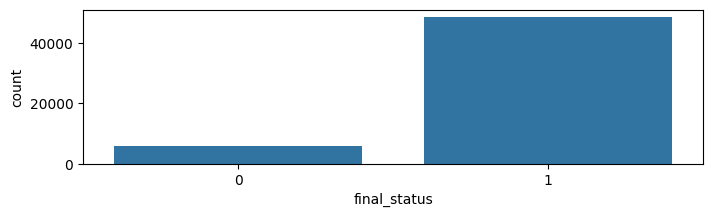

In [ ]:
fig, ax = plt.subplots(figsize=(8, 2))
sns.countplot(data=df, x='final_status')
plt.show()

In [ ]:
df['final_status'].value_counts()

final_status
1    48498
0     5832
Name: count, dtype: int64

In [ ]:
df['final_status'].value_counts(normalize=True).mul(100)

final_status
1    89.265599
0    10.734401
Name: proportion, dtype: float64

In [ ]:
# se filtran los pedidos entregados y los cancelados
entregados = df[df['final_status'] == 1]
cancelados = df[df['final_status'] == 0]

In [ ]:
# se selecciona de forma aleatoria el mismo número de pedidos entregados que cancelados para equilibrar el dataset, sin posibilidad de repetir pedido con sample
entregados = entregados.sample(len(cancelados), replace=False, random_state=42)

In [ ]:
# se juntan los dataframes de entregados y cancelados en el df_train con concat
df = pd.concat([entregados, cancelados])

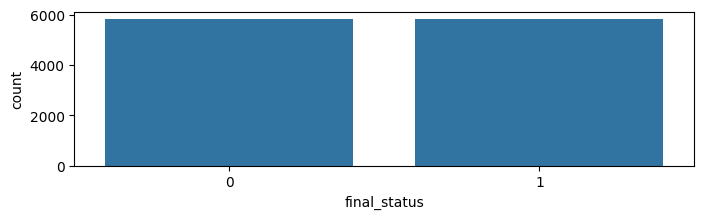

In [ ]:
fig, ax = plt.subplots(figsize=(8, 2))
sns.countplot(data=df, x='final_status')
plt.show()

## correlaciones

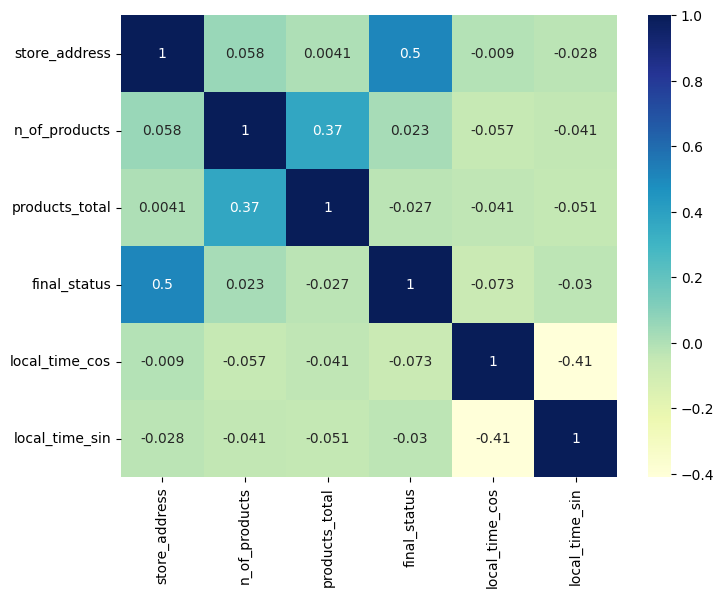

In [ ]:
# se grafica las correlaciones con un mapa de calor heatmap
plt.rcParams['figure.figsize'] = 8, 6
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="YlGnBu")
plt.show()

La target casí no tiene correlación con ninguna feature: el modelo no será bueno.

## one hot encoding

In [ ]:
df = pd.get_dummies(df)
df_pred = pd.get_dummies(df_pred)

In [ ]:
df

,store_address,n_of_products,products_total,final_status,local_time_cos,local_time_sin,country_code_AR,country_code_EC,country_code_EG,country_code_ES,...,country_code_IT,country_code_MA,country_code_PE,country_code_RO,country_code_TR,country_code_UA,country_code_otro,payment_status_DELAYED,payment_status_NOT_PAID,payment_status_PAID
37644,0.931870,4,6.45,1,-0.500000,-0.866025,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
19618,0.839268,2,5.65,1,0.258819,-0.965926,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
8109,0.987442,2,7.24,1,0.707107,-0.707107,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
26542,0.917503,1,32.68,1,-0.965926,0.258819,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
6158,0.867737,13,17.63,1,-0.500000,-0.866025,False,False,False,False,...,False,True,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54258,0.782013,3,12.53,0,0.258819,-0.965926,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
54272,0.941591,1,10.90,0,0.258819,-0.965926,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
54284,0.716074,2,21.50,0,0.500000,-0.866025,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
54290,0.915969,1,2.01,0,0.500000,-0.866025,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True


In [ ]:
df_pred

,store_address,n_of_products,products_total,local_time_cos,local_time_sin,country_code_AR,country_code_EC,country_code_ES,country_code_MA,country_code_TR,country_code_UA,country_code_otro,payment_status_NOT_PAID,payment_status_PAID,payment_status_REFOUND
0,0.952106,11,15.99,-1.836970e-16,-1.000000,False,False,True,False,False,False,False,False,False,True
1,0.836957,2,1.79,-1.836970e-16,-1.000000,False,False,False,True,False,False,False,True,False,False
2,0.967858,5,29.89,-9.659258e-01,-0.258819,False,False,False,False,False,False,True,False,True,False
3,0.940363,1,1.47,-7.071068e-01,0.707107,False,False,False,False,True,False,False,False,True,False
4,0.843642,1,4.20,7.071068e-01,-0.707107,True,False,False,False,False,False,False,False,True,False
5,0.913890,6,18.73,-9.659258e-01,0.258819,False,False,False,False,False,True,False,False,True,False
6,0.849013,1,3.80,5.000000e-01,-0.866025,False,False,True,False,False,False,False,False,True,False
7,0.885050,1,6.25,-8.660254e-01,-0.500000,False,False,False,False,False,False,True,False,True,False
8,0.851702,2,14.50,7.071068e-01,-0.707107,False,False,True,False,False,False,False,False,True,False
9,0.909711,1,21.10,-1.836970e-16,-1.000000,False,True,False,False,False,False,False,False,True,False


In [ ]:
df_pred.shape

(10, 15)

## feature importance

averigua las variables más utilizadas en un modelo de árbol de decisión

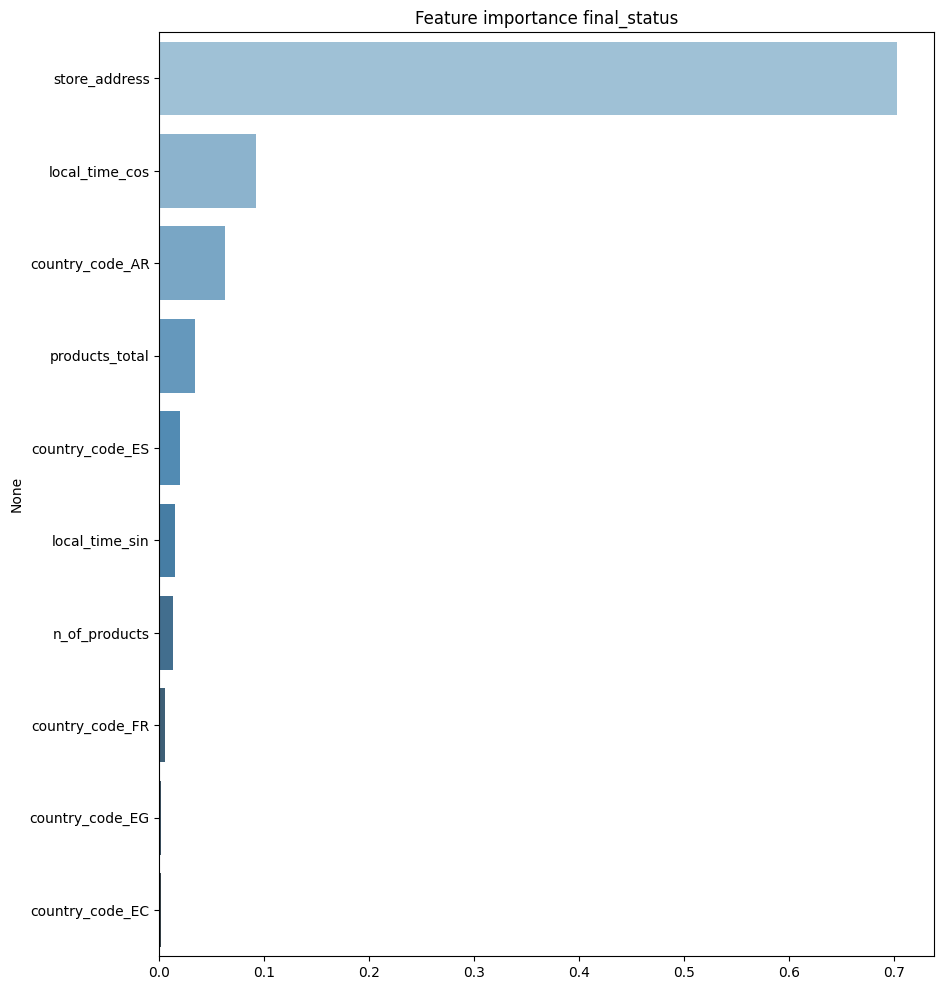

In [ ]:
params = {'random_state': 42, 'n_jobs': 4, 'n_estimators': 100, 'max_depth': 4}

x, y = df.drop('final_status',axis=1), df['final_status']
# entrena un RandomForest Classifier
clf = RandomForestClassifier(**params)
clf = clf.fit(x, y)
# Plotea las 10 mejores Features importances
features = clf.feature_importances_[:10]
columnas = x.columns[:10]
imp = pd.Series(data=features, index=columnas).sort_values(ascending=False)
plt.figure(figsize=(10,12))
plt.title("Feature importance {}".format('final_status'))
ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')
plt.show()

## split train/test

In [ ]:
# se guarda la target como y y las features como X
y = df['final_status']
X = df.drop('final_status', axis=1)

# se guarda un 30% de datos para el test y un 70% para el train con train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
X_train.shape

(8164, 20)

In [ ]:
X_test.shape

(3500, 20)

## estandarización

In [ ]:
# se estandarizan las variables con StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)   # estandariza y define la regla de estandarización
X_test = scaler.transform(X_test)         # estandariza según la regla definida con el X_train, con la media de X_train

In [ ]:
# # se estandarizan las variables del dataset a predecir según la regla definida con el X_train
# df_pred = scaler.transform(df_pred)


# # da error porque no tiene el mismo número de variables y con el mismo nombre que el dataset de entrenamiento

### shape dataset predicción

In [ ]:
col_df_pred = df_pred.columns
col_df_pred

Index(['store_address', 'n_of_products', 'products_total', 'local_time_cos',
       'local_time_sin', 'country_code_AR', 'country_code_EC',
       'country_code_ES', 'country_code_MA', 'country_code_TR',
       'country_code_UA', 'country_code_otro', 'payment_status_NOT_PAID',
       'payment_status_PAID', 'payment_status_REFOUND'],
      dtype='object')

In [ ]:
col_df = df.columns
col_df

Index(['store_address', 'n_of_products', 'products_total', 'final_status',
       'local_time_cos', 'local_time_sin', 'country_code_AR',
       'country_code_EC', 'country_code_EG', 'country_code_ES',
       'country_code_FR', 'country_code_IT', 'country_code_MA',
       'country_code_PE', 'country_code_RO', 'country_code_TR',
       'country_code_UA', 'country_code_otro', 'payment_status_DELAYED',
       'payment_status_NOT_PAID', 'payment_status_PAID'],
      dtype='object')

In [ ]:
# columnas que están en el dataset de entrenamiento pero no están en el dataset de predicción

col_faltantes = []
for col in col_df:
  if col not in col_df_pred:
    col_faltantes.append(col)
col_faltantes

['final_status',
 'country_code_EG',
 'country_code_FR',
 'country_code_IT',
 'country_code_PE',
 'country_code_RO',
 'payment_status_DELAYED']

In [ ]:
# elimino la target de la lista

col_faltantes.remove('final_status')

In [ ]:
# añadimos las columnas faltante al dataset de predicción con 0

for col in col_faltantes:
  df_pred[col] =[0]*len(df_pred)
df_pred

,store_address,n_of_products,products_total,local_time_cos,local_time_sin,country_code_AR,country_code_EC,country_code_ES,country_code_MA,country_code_TR,...,country_code_otro,payment_status_NOT_PAID,payment_status_PAID,payment_status_REFOUND,country_code_EG,country_code_FR,country_code_IT,country_code_PE,country_code_RO,payment_status_DELAYED
0,0.952106,11,15.99,-1.836970e-16,-1.000000,False,False,True,False,False,...,False,False,False,True,0,0,0,0,0,0
1,0.836957,2,1.79,-1.836970e-16,-1.000000,False,False,False,True,False,...,False,True,False,False,0,0,0,0,0,0
2,0.967858,5,29.89,-9.659258e-01,-0.258819,False,False,False,False,False,...,True,False,True,False,0,0,0,0,0,0
3,0.940363,1,1.47,-7.071068e-01,0.707107,False,False,False,False,True,...,False,False,True,False,0,0,0,0,0,0
4,0.843642,1,4.20,7.071068e-01,-0.707107,True,False,False,False,False,...,False,False,True,False,0,0,0,0,0,0
5,0.913890,6,18.73,-9.659258e-01,0.258819,False,False,False,False,False,...,False,False,True,False,0,0,0,0,0,0
6,0.849013,1,3.80,5.000000e-01,-0.866025,False,False,True,False,False,...,False,False,True,False,0,0,0,0,0,0
7,0.885050,1,6.25,-8.660254e-01,-0.500000,False,False,False,False,False,...,True,False,True,False,0,0,0,0,0,0
8,0.851702,2,14.50,7.071068e-01,-0.707107,False,False,True,False,False,...,False,False,True,False,0,0,0,0,0,0
9,0.909711,1,21.10,-1.836970e-16,-1.000000,False,True,False,False,False,...,False,False,True,False,0,0,0,0,0,0


In [ ]:
# columnas que están en el dataset de predicción pero no en el dataset de entrenamiento (nueva categoría)

col_sobrantes = []
for col in col_df_pred:
  if col not in col_df:
    col_sobrantes.append(col)
col_sobrantes

['payment_status_REFOUND']

In [ ]:
# eliminamos las columnas sobrantes, ya que el modelo no ha sido entrenado con ellas

df_pred.drop(col_sobrantes, axis=1, inplace=True)

In [ ]:
# verificamos que los dataset tienen el mismo número de variables

df_pred.shape[1] == X.shape[1]

True

In [ ]:
# ponemos las columnas del dataset de predicción en el mismo orden que el de entrenamiento con reindex

columnas = X.columns
df_pred = df_pred.reindex(columns=columnas)

In [ ]:
# ya se pueden estandarizar las variables del dataset a predecir según la regla definida con el X_train con transform
df_pred = scaler.transform(df_pred)

# modelado



*   defino el modelo
*   entreno el dataset de train
*   predigo el dataset de test
*   analizo las metricas



## entrenamiento

In [ ]:
def medicion(y_t, y_p):
  """imprime la curva ROC y el AUC"""

  # calculate the fpr and tpr for all thresholds of the classification
  fpr, tpr, threshold = metrics.roc_curve(y_t, y_p)
  roc_auc = metrics.auc(fpr, tpr)

  # para añadir el gráfico
  # method I: plt
  import matplotlib.pyplot as plt
  plt.figure(figsize=(8, 6))
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()
  return roc_auc

In [ ]:
def entrenar(Xtrain, Xtest, ytrain, ytest):
  """entrena 6 módelos.
      imprime la curva roc de cada módelo junto al valor AUC
      devuelve un dataframe con los valores de AUC redondeados a 5 decimales para cada módelo"""

  # creamos la lista de auc vacía
  lista_aucs = []

  # Support Vector Machine
  print('Support Vector Machine')
  svclassifier = SVC(max_iter=20)

  svclassifier.fit(Xtrain, ytrain)
  y_pred = svclassifier.predict(Xtest)

  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('SVC', round(roc_auc, 5)))

  # Regresión logística
  print('Regresión logística')
  lr = LogisticRegression(max_iter=40)

  lr.fit(Xtrain, ytrain)
  y_pred = lr.predict(Xtest)

  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('regresión logística', round(roc_auc, 5)))

  # RidgeClassifier
  print('RidgeClassifier')
  rc = RidgeClassifier(max_iter=40)

  rc.fit(Xtrain, ytrain)
  y_pred = rc.predict(Xtest)

  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('RidgeClassifier', round(roc_auc, 5)))

  # Decision tree classsifier
  print('Decision tree classsifier')
  dt_base = DecisionTreeClassifier(random_state=42)

  dt_base.fit(Xtrain, ytrain)
  y_pred = dt_base.predict(Xtest)

  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('decision tree classifier', round(roc_auc, 5)))

  # Random forest
  print('Random forest')
  rf_base = RandomForestClassifier(random_state=42)

  rf_base.fit(Xtrain, ytrain)
  y_pred = rf_base.predict(Xtest)

  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('random forest', round(roc_auc, 5)))

  # Gradient boosting
  print('Gradient boosting')
  gbc_base = GradientBoostingClassifier(random_state=42)

  gbc_base.fit(Xtrain, ytrain)
  y_pred = gbc_base.predict(Xtest)

  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('gradient boosting', round(roc_auc, 5)))

  # XGBClassifier
  print('XGBClassifier')
  xgbc_base = XGBClassifier(random_state=42)

  xgbc_base.fit(Xtrain, ytrain)
  y_pred = xgbc_base.predict(Xtest)

  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('XGB classifier', round(roc_auc, 5)))

  # CatBoostClassifier
  print('CatBoostClassifier')
  cat_base = CatBoostClassifier(verbose=False, random_state=42)

  cat_base.fit(Xtrain, ytrain)
  y_pred = cat_base.predict(Xtest)

  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('CatBoost Classifier', round(roc_auc, 5)))

  df_aucs = pd.DataFrame(lista_aucs, columns=['modelos', 'AUC'])
  df_aucs = df_aucs.set_index('modelos')

  return df_aucs

Support Vector Machine


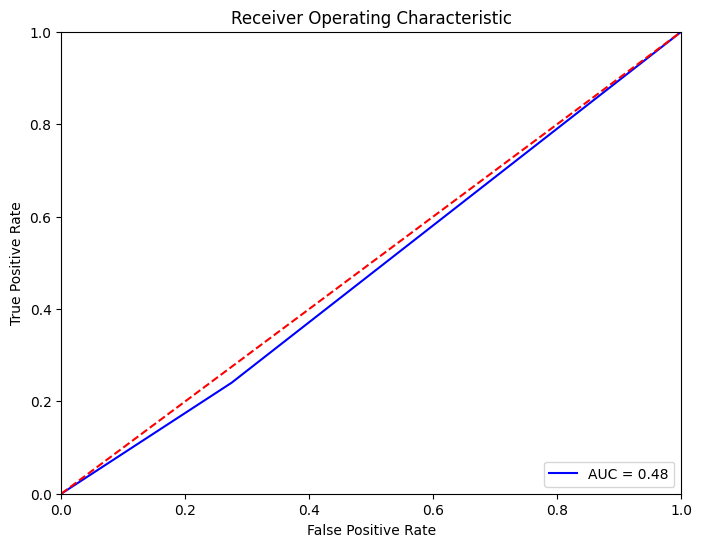

Regresión logística


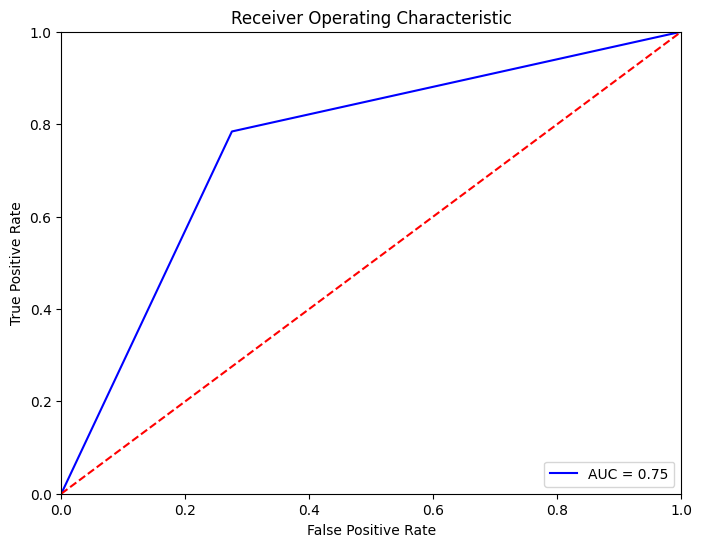

RidgeClassifier


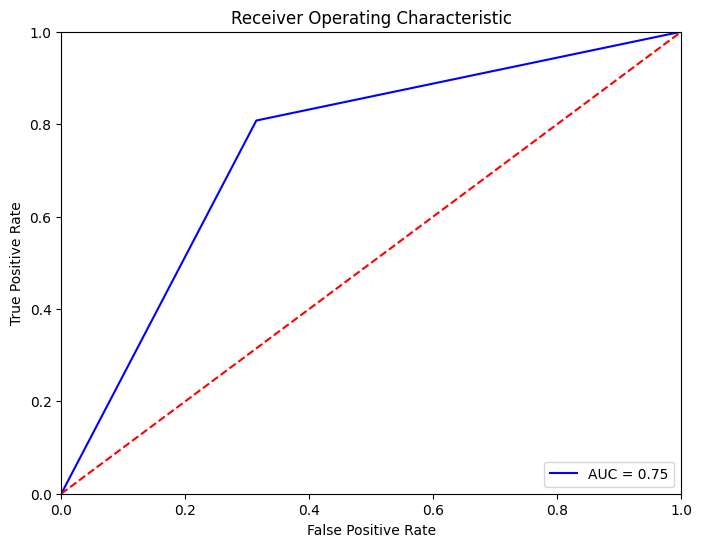

Decision tree classsifier


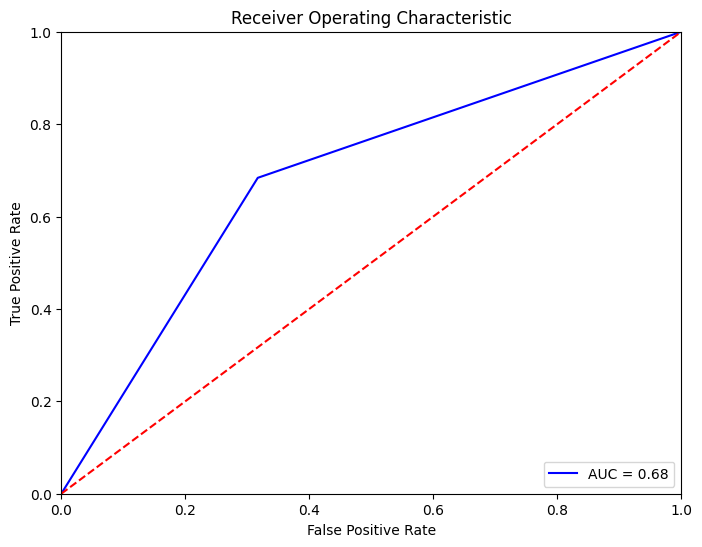

Random forest


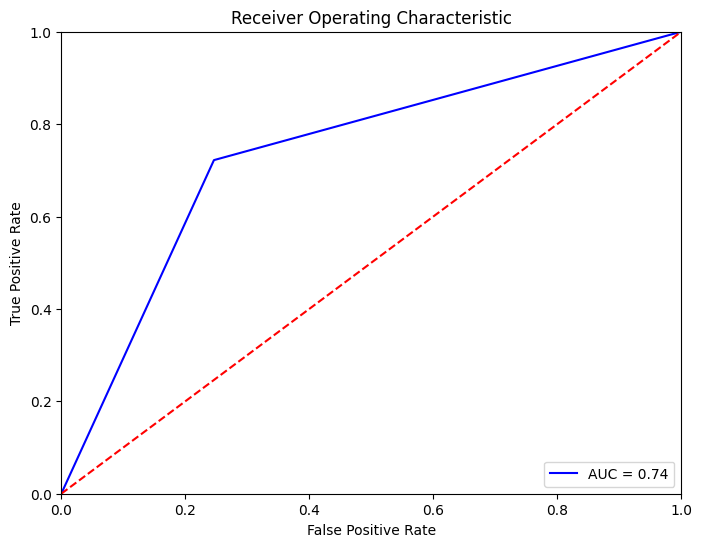

Gradient boosting


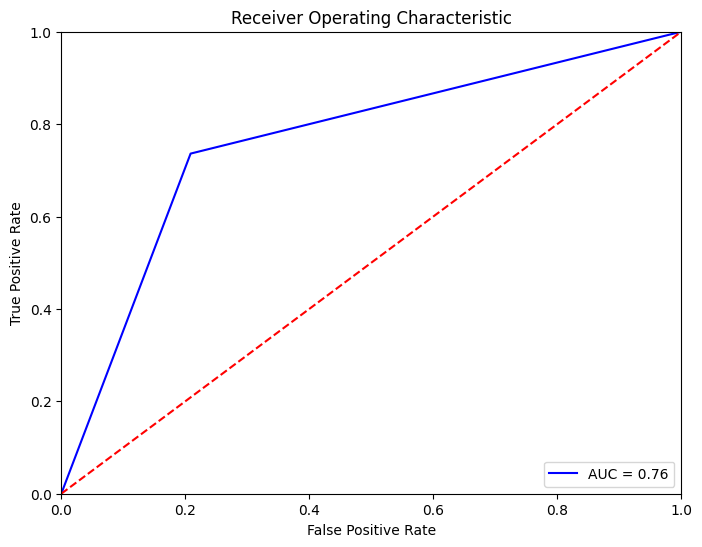

XGBClassifier


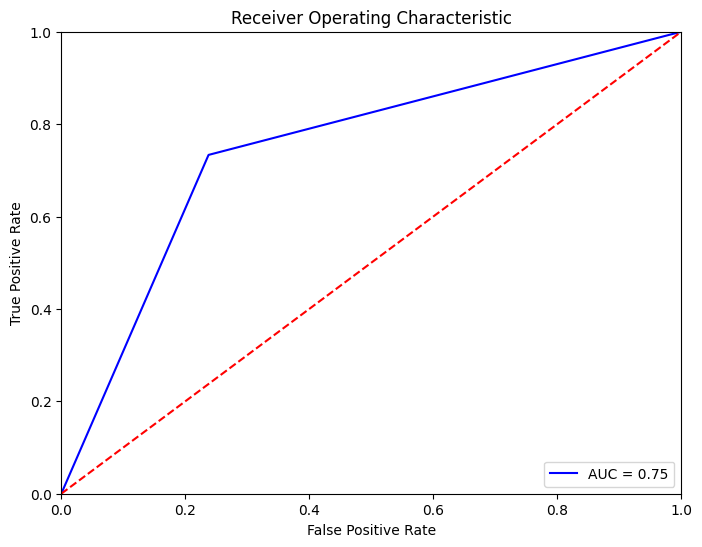

CatBoostClassifier


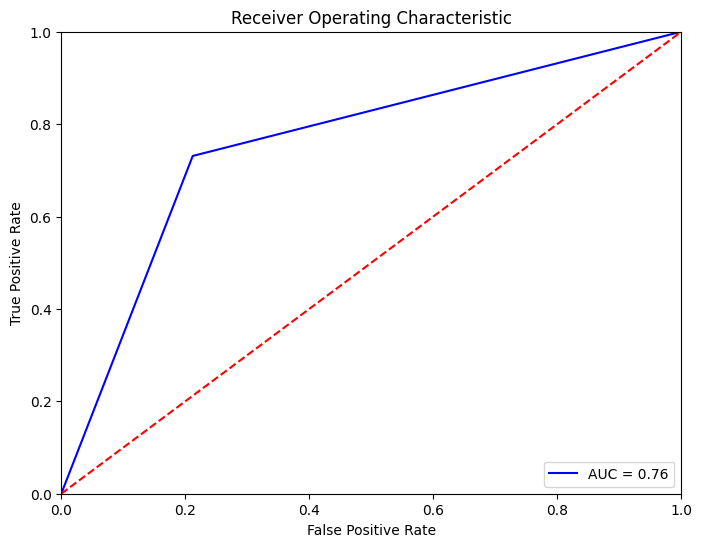

In [ ]:
aucs = entrenar(X_train, X_test, y_train, y_test)

## medición

In [ ]:
aucs

,AUC
modelos,
SVC,0.48276
regresión logística,0.75445
RidgeClassifier,0.74659
decision tree classifier,0.68342
random forest,0.73793
gradient boosting,0.76381
XGB classifier,0.74791
CatBoost Classifier,0.75953


El mejor modelo es el gradient boosting

## hiperparametrización

In [ ]:
# gridsearch
parameters = {'learning_rate': [0.03, 0.05, 0.1, 0.15],
              'n_estimators': [100, 300, 500],
              'max_depth': [3, 4, 5],
              'max_leaf_nodes': [None, 2, 3]}

In [ ]:
gbc_hp =  GradientBoostingClassifier()

In [ ]:
# gbc_grid = GridSearchCV(gbc_hp,
#                         parameters,
#                         cv=2,
#                         verbose=True)

# gbc_grid.fit(X_train, y_train)

In [ ]:
# se imprime el modelo con los mejores parametros
# gbc_grid.best_estimator_

In [ ]:
# se introducen los parametros del griedsearch
gbc = GradientBoostingClassifier(learning_rate=0.1, max_leaf_nodes=None, random_state=42)

gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)

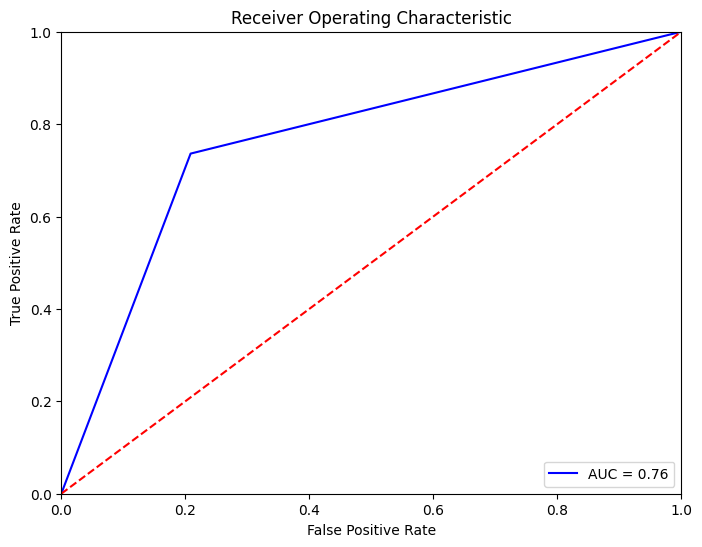

0.7638073315993473


In [ ]:
roc_auc = medicion(y_test, y_pred)
print(roc_auc)

medir cuanto ganamos con el gridsearch: con los parametros y sin parametros


# predicción

In [ ]:
# se hace la predicción con predict

pred = gbc.predict(df_pred)
pred

array([1, 0, 1, 1, 0, 1, 0, 0, 0, 1])

In [ ]:
# se hace la predicción con la probabilidad para cada categoría con predict_proba

pred_proba = gbc.predict_proba(df_pred)
pred_proba

array([[0.16987389, 0.83012611],
       [0.88315662, 0.11684338],
       [0.13756013, 0.86243987],
       [0.2176806 , 0.7823194 ],
       [0.69419006, 0.30580994],
       [0.12851988, 0.87148012],
       [0.73660003, 0.26339997],
       [0.5458768 , 0.4541232 ],
       [0.69026103, 0.30973897],
       [0.19746239, 0.80253761]])

In [ ]:
pred_proba2 = []
for tupla in pred_proba:
  pred_proba2.append(tupla[1])
pred_proba2

[0.8301261143656097,
 0.11684338322709288,
 0.8624398735114364,
 0.7823194017327559,
 0.3058099394891035,
 0.8714801195893596,
 0.26339996638533336,
 0.4541232028362887,
 0.3097389707600173,
 0.8025376121098022]

In [ ]:
# creo un dataframe con mi predicción y las probabilidades
df_prediccion = pd.DataFrame()
df_prediccion['order_id'] = order_ids
df_prediccion['prediccion'] = pred
df_prediccion['prediccion_sin_redondeo'] = pred_proba2
df_prediccion

,order_id,prediccion,prediccion_sin_redondeo
0,32240990,1,0.830126
1,32960491,0,0.116843
2,32430153,1,0.862440
3,32777553,1,0.782319
4,32324328,0,0.305810
5,33047576,1,0.871480
6,33293677,0,0.263400
7,32073867,0,0.454123
8,32732256,0,0.309739
9,32152540,1,0.802538
